# Композиция функций


Из курса математического анализа мы знаем оператор композиции функций

$$
f : X \rightarrow Y 
$$
$$
g: Y \rightarrow Z 
$$
$$ 
(f \circ g) (x) = f(g(x))
$$

И мы можем перенять этот подход, когда разрабатываем логику приложения, последовательно применяя функции

_Кстати в чисто функциональном языке `Haskell` оператором композиции функции является как раз точка `.` , из-за чего синтаксис выглядит очень математическим_

__Посмотрим на композицию функций в Python, какие сложности и возможности с ним возникают__

## Выведим в консоль квадраты первых 10 целых чисел

Для примера посмотрим на решение такой задачи

In [148]:
print(                      # Вывести 
    *map(lambda x: x ** 2,  # Квадраты
         range(10)))        # Первых 10 целых чисел

0 1 4 9 16 25 36 49 64 81


Однако такой синтаксис имеет большую вложенность, а также функции применяются изнутри (в начале `range`, потом `square` и в конце `print`), что часто неудобно и не так читаемо

При большом количестве функций часто удобнее просто создавать каждый раз новую переменную на каждом этапе

In [58]:
first_10_z = range(10)
squared_numbers = map(lambda x: x ** 2, first_10_z)

print(*squared_numbers)

0 1 4 9 16 25 36 49 64 81


Но и такой стиль нравится не всем, выходит больше символов, а придумать названия переменных достаточно сложный и важный процесс (как мы помним из [Clean Code](https://inprogrammer.com/wp-content/uploads/2022/01/Martin-Robert-Cecil-Clean-code_-a-handbook-of-agile-software-craftsmanship-2009-Prentice-Hall-libgen.lc_.pdf) от Роберта Мартина)

## Как быть?

Можно реализовать функцию `compose`, которая принимает на вход функции, которые нужно композировать и возвращает функцию их композиции

In [18]:
from typing import Callable

функция compose - __Функция высшего порядка__. Она принимает функцию как аргумент и возвращает новую функцию

In [67]:
def compose(*functions: Callable) -> Callable:
    
    # Создадим функцию из композиции всех функций
    def wrapper(*args, **kwargs):

        # Последовательно применим функции друг к другу
        result = functions[-1](*args, **kwargs)
        for function in reversed(functions[:-1]):
            result = function(result)

        # Вернем результат
        return result

    # Вернем их композицию
    return wrapper    

### Чем это нам поможет?

Теперь мы сможем более красиво композировать функции

In [70]:
# За место map
square = lambda seq: [el * el for el in seq]

In [68]:
compose(
    print,   # Вывести
    square,  # Квадраты
    range    # Первых n целых чисел
)(10)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


Получили тот же результат, как при обычной композиции, однако в более читаемой форме

В таком решении есть своя красота, однако так мало кто делает, т.к. решение требует задействовать дополнительную функцию `compose` и остается проблема того, что нужно читать код с конца

In [147]:
result = list()

for n in range(10):
    result.append(n ** 2)

print(result)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]



### Чтение кода с конца

На самом деле такой подход даже кому то нравится, т.к. его часто проще перевести на естественный язык. Например `LISP`-подобные языки, такие как `Clojure`, полностью построены в таком стиле

Взглянем на аналогичный код на `Clojure`

```clojure
(println (take 10 (map (fn [x] (* x x)) (range))))
```

Для неподготовленного читателя кажется очень непонятно, но с комментариями становится яснее

```clojure
(println                   ;; Вывести
  (take 10                 ;; Первые 10
    (map (fn [x] (* x x))  ;; Квадратов
      (range))))           ;; Целых чисел
 ```

_Решение права может напугать переменной `range` с бесконечным числом целых чисел_

Но такой стиль заходит не всем, хоть и имеет свои плюсы (например так проще удалять скобки внутренних кусков кода)

# Цепочки вызовов и pipe-оператор

Есть более читаемый вариант последовательного применения функций, например __паттерн цепочек вызовов__ (Function Chaining Pattern). Это паттерн для последовательного декларативного вызова функций

Этот паттерн очень распространен в таких языках, как `Rust`, `JavaScript` и `Haskell`

## Как сделано в Python?
В стандартном `Python` есть некоторые классы, для которых определены методы так, чтобы можно было создавать из них цепочки вызовов методов, например класс `str`, однако не для всех :(

In [75]:
text = " Как же я люблю fghj "

text.strip().capitalize().replace("fghj", "фп")

'Как же я люблю фп'

Или более читаемый вариант:

In [76]:
(text
 .strip()
 .capitalize()
 .replace("fghj", "фп"))

'Как же я люблю фп'

В таком случае мы видим последовательно какие функции (методы) применяются к нашему обьекту: в начале `strip()`, далее `capitalize()` и в конце `.replace("fghj", "фп")`

### Как реализовать этот паттерн в своем классе?

На самом деле не сложно. Достаточно возвращать новый обьект этого же класса в каждом методе

Данный паттерн позволяет хорошо инкапсулировать логику обьекта, делает его иммутабельным и создает декларативный API для работы с ним

Создадим искусственный пример с классом последовательности `Seq`

In [144]:
class Seq:
    def __init__(self, data):
        self._data = data

    def map(self, func: Callable): return Seq(map(func, self._data))

    def filter(self, func: Callable): return Seq(filter(func, self._data))

    # Применить все функции и вернуть данные
    def join(self) -> list: return list(self._data)

In [143]:
cars = Seq([
    {'model': 'rapid', 'year': 2016},
    {'model': 'rio', 'year': 2013},
    {'model': 'mondeo', 'year': 2011},
    {'model': 'octavia', 'year': 2014}
])


(cars
 .filter(lambda car: car['year'] > 2013)
 .map(lambda car: car['model'])
 .join())

['rapid', 'octavia']

Chaining является декларативным способом описания бизнес логики, что часто является лучшей практикой по сравнению с императивным кодом

Также есть мнение, что если вы не можете описать ваш алгоритм в виде такой цепочки вызовов, то у вас плохой дизайн кода

В `Python` к сожалению API для работы с последовательностями (списками и кортежами) имеет `LISP`-подобный стиль, из-за чего комьюнити реализовали библиотеки с этим паттерном для работы с данными в виде последовательностей, рассмотрим популярные из них

## Pandas

`pandas` скорее всего самая популярная библиотека в Python для работы с табличными данными. Он имеет множество функциональных техник, и chaining функций не исключение. Цепочки вызовов в `pandas` хорошо реализованы и постоянно используются комьюнити

_Если вы хорошо знакомы с pandas, то советую почитать статью [с продвинутыми техниками цепочек вызовов](https://habr.com/ru/articles/722170/)_

In [84]:
import pandas as pd

Мы можем красиво и декларативно решить нашу задачу используя цепочки вызовов

In [89]:
df = pd.DataFrame({'numbers': range(25)})

(df
 .numbers
 .apply(lambda x: x ** 2)
 .head(10)
 .to_list())

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

Но и более интересные и сложные задачи с реальными данными. Например визуализируем топ 5 стран по экспорту нефти и нефтепродуктов, а также посчитаем их суммарный экспорт

<Axes: xlabel='Country'>

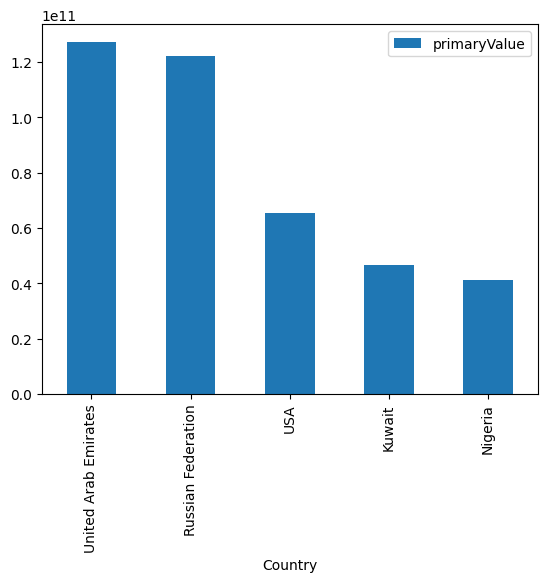

In [317]:
(pd.read_csv('Comtrade Data.csv', index_col='Unnamed: 0') # Открываем таблицу
    .drop_duplicates(subset=['Country'])                  # Удаляем повторы
    .sort_values(by='primaryValue', ascending=False)      # Сотрируем по обьему экспорта 
    .drop(columns=['netWgt', 'flowCode'])                 # Удаляем лишние столбцы
    .head(5)                                              # Возвращаем топ 5
    .plot.bar(x='Country', y='primaryValue'))             # Строим график              

Остановим наш обзор библиотек для работы с данными на `pandas`, потому что все `pyspark`, `polars`, `SQLAlchemy` ... реализуют схожие интерфейсы и нужны для схожих задач

## PyFunctional

[Функциональная библиотека](https://github.com/EntilZha/PyFunctional) для работы с контейнерами данных. Вдохновлена языком `Scala`, добавляет в язык обьект `seq` - прямо как тот что мы сделали, но с более обширним API, ленивым выполнением и поддержкой параллелизма

_ну прям ФП!_

например помимо стандартного интерфейса для эндофунктора, обьект seq имеет методы `groupby` И `join`

In [ ]:
!pip install pyfunctional

In [243]:
from functional import seq

Решим нашу задачу

In [306]:
seq(range(10)).map(lambda x: x ** 2)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

Самое кратенькое решение пока что

#### Интеграция с Pandas

а также эта библиотека имеет интеграцию с `pandas`, обьект seq должен уметь строить датафрейм на основе pandas.DataFrame, но делает это очень плохо. Однако, я нашел костыльный способ

In [268]:
from collections import namedtuple

In [304]:
Row = namedtuple(
    'Row',
    ['reporterCode', 'primaryValue', 'netWgt', 'flowCode']
)

seq_df = seq(
    [Row(
        row[1].reporterCode,
        row[1].primaryValue,
        row[1].netWgt,
        row[1].flowCode
    ) 
     for row in df.iterrows()]
)

Посмотрим топ 5 стран по обьему экспорта нефти и нефтепродуктов

In [303]:
(seq_df
 .sorted(key=lambda row: row.primaryValue, reverse=True)
 .take(5))

reporterCode,primaryValue,netWgt,flowCode
United Arab Emirates,1.27284e+11,2.7173e+11,X
Russian Federation,1.22229e+11,2.69175e+11,X
Canada,6.81009e+10,1.45386e+11,X
USA,6.53232e+10,1.39456e+11,X
Canada,5.64311e+10,1.20472e+11,X


Не хватает конечно функционала пока что для работы с данными как в Pandas)

# Pipe-оператор

Другой способ создания __конвейера__ вызовов является pipe-оператор (обычно `|>`, но может быть `|`)

Он берет все данные которые в него пришли и передает в следующую функцию

Этот оператор существует в множестве языков, таких как `Elixir`, `F#`, `OCaml`, даже в `Bash` и ВНИМАНИЕ !!! `R`

Рассмотрим например его синтаксис в `F#`:

```f#
[1 .. 10]
|> List.map (fun x -> x * x)
|> List.iter (printfn "%d")

```

Достаточно декларативно и чисто, а оператор `|>` будто бы явно указывает, что данные передаваемые из предыдущей функции передаются в следующую

### Как это сделано в Python?

Есть библиотека [pipe](https://github.com/JulienPalard/Pipe)!

In [223]:
from pipe import select, take, Pipe

In [228]:
println = Pipe(lambda x: print(*x))

(range(10)
 | select(lambda x: x ** 2) 
 | println)

0 1 4 9 16 25 36 49 64 81


Из плюсов - красивый и удобный API, множество удобных встроенных функций, возможность добавлять свои функции

In [216]:
@Pipe
def my_function(iterable):
    print('Я в пайплайне!')
    return iterable

И аналогично встраивать без каких либо проблем

In [242]:
(range(10)
 | select(lambda x: x ** 2)
 | my_function
 | println)

Я в пайплайне!
0 1 4 9 16 25 36 49 64 81
